In [1]:
import numpy as np
import pandas as pd
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt

## train = pd.read_csv("/kaggle/input/titanic/train.csv")
## test  = pd.read_csv("/kaggle/input/titanic/test.csv")

train = pd.read_csv("./train.csv")
test  = pd.read_csv("./test.csv")

y = train["Survived"].astype(int)
X = train.drop(columns=["Survived"])

print("X:", X.shape, "y:", y.shape, "test:", test.shape)
display(X.head(3))

X: (891, 11) y: (891,) test: (418, 11)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


<Axes: >

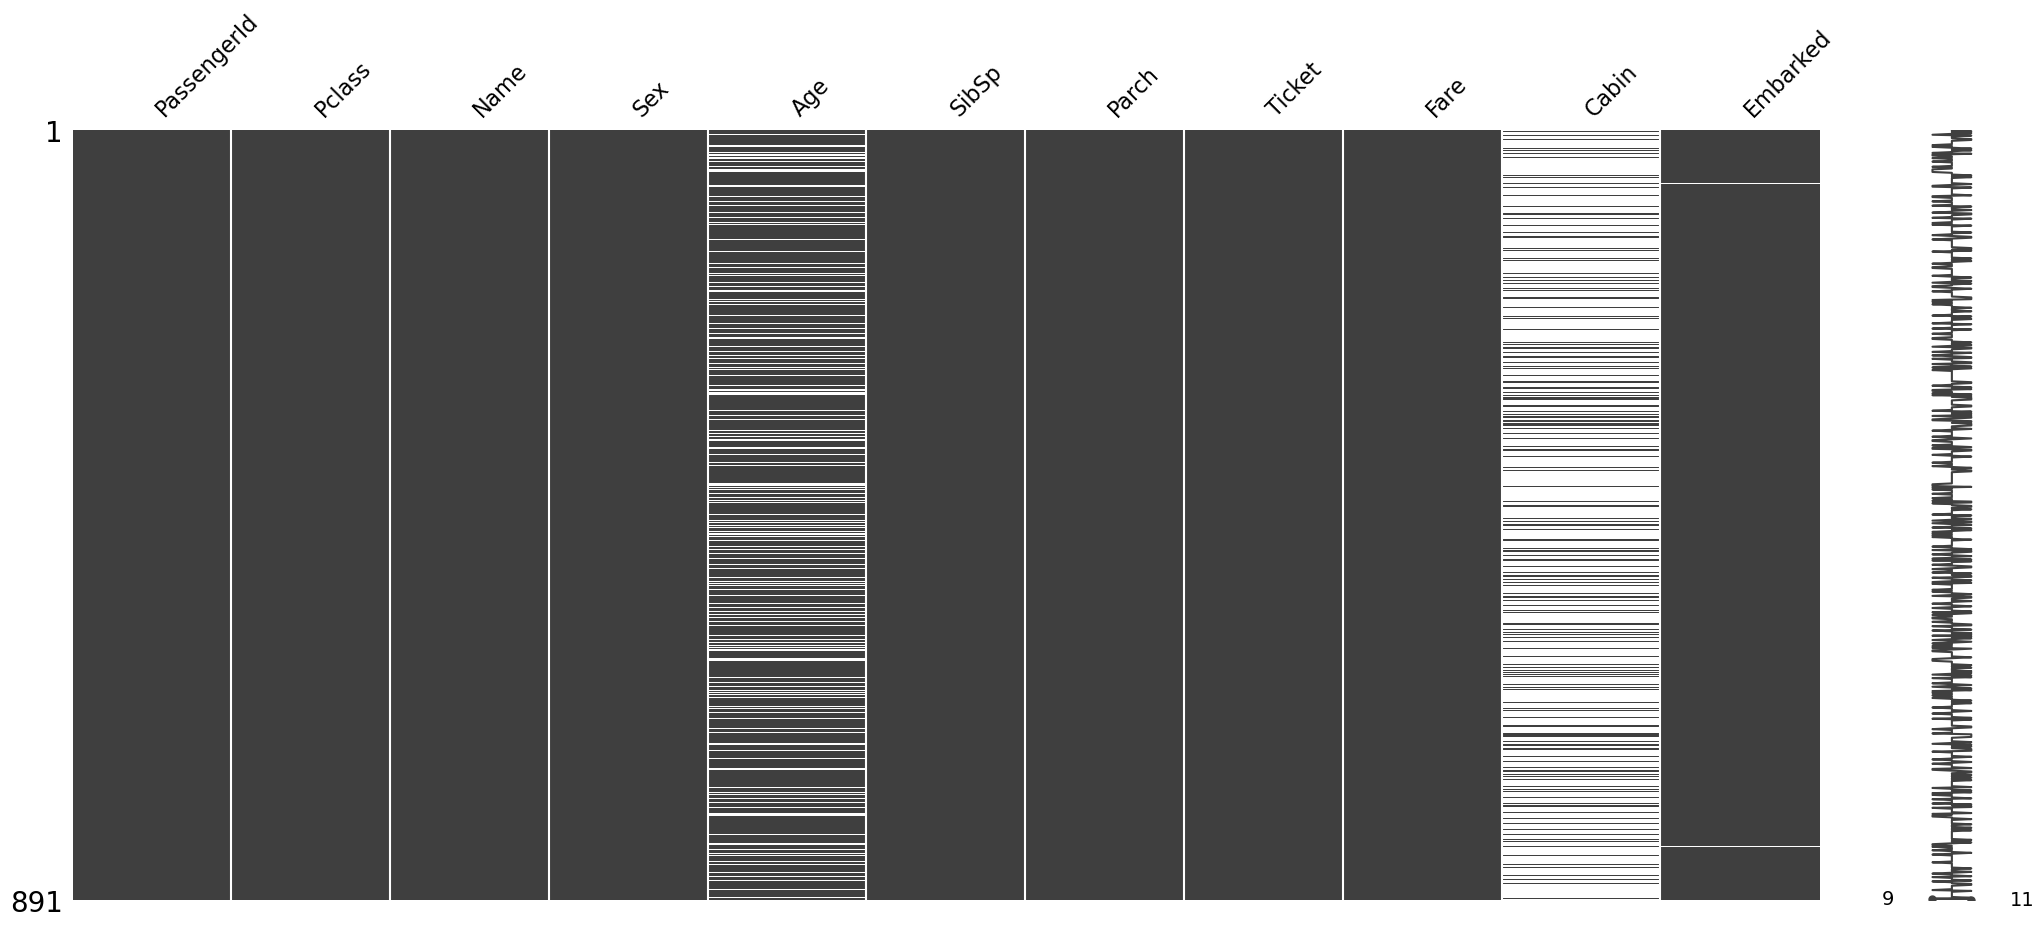

In [2]:
msno.matrix(X)

In [3]:
def profile_columns(df, n_examples=3):
    rows = []
    for col in df.columns:
        s = df[col]
        rows.append({
            "col": col,
            "dtype": str(s.dtype),
            "missing_cnt": int(s.isna().sum()),
            "missing_pct": float(s.isna().mean() * 100),
            "n_unique": int(s.nunique(dropna=True)),
            "examples": s.dropna().astype(str).head(n_examples).tolist()
        })
    prof = pd.DataFrame(rows).sort_values(["missing_pct","n_unique"], ascending=[False, False])
    return prof

prof = profile_columns(X)
display(prof)


,col,dtype,missing_cnt,missing_pct,n_unique,examples
9,Cabin,object,687,77.104377,147,"[C85, C123, E46]"
4,Age,float64,177,19.865320,88,"[22.0, 38.0, 26.0]"
10,Embarked,object,2,0.224467,3,"[S, C, S]"
0,PassengerId,int64,0,0.000000,891,"[1, 2, 3]"
2,Name,object,0,0.000000,891,"[Braund, Mr. Owen Harris, Cumings, Mrs. John B..."
7,Ticket,object,0,0.000000,681,"[A/5 21171, PC 17599, STON/O2. 3101282]"
8,Fare,float64,0,0.000000,248,"[7.25, 71.2833, 7.925]"
5,SibSp,int64,0,0.000000,7,"[1, 1, 0]"
6,Parch,int64,0,0.000000,7,"[0, 0, 0]"
1,Pclass,int64,0,0.000000,3,"[3, 1, 3]"


In [4]:
## "Cabin" 컬럼의 결측치 비율과 일부 예시 확인
## X["Cabin"].isna().mean(), X["Cabin"].dropna().head(10).tolist()
deck = X["Cabin"].fillna("U").astype(str).str[0]
deck.value_counts().head(20)


Cabin
U    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: count, dtype: int64

In [5]:
## "Name" 컬럼의 일부 예시 확인
X["Name"].sample(10).tolist()


['Baumann, Mr. John D',
 'Harris, Mrs. Henry Birkhardt (Irene Wallach)',
 'Allen, Mr. William Henry',
 'Radeff, Mr. Alexander',
 'Beane, Mrs. Edward (Ethel Clarke)',
 'Harris, Mr. Henry Birkhardt',
 'Daly, Mr. Eugene Patrick',
 "O'Brien, Mr. Timothy",
 'Patchett, Mr. George',
 'Kilgannon, Mr. Thomas J']

In [6]:
## "Ticket" 컬럼의 고유값 개수와 일부 예시 확인
X["Ticket"].nunique(), X["Ticket"].head(10).tolist()
## 전체 891, 고유값 681, missing 0 -> 중복값 많음


(681,
 ['A/5 21171',
  'PC 17599',
  'STON/O2. 3101282',
  '113803',
  '373450',
  '330877',
  '17463',
  '349909',
  '347742',
  '237736'])

In [7]:
## Age, Embarked, Fare 결측치 비율 확인 
X[["Age","Embarked","Fare"]].isna().mean().sort_values(ascending=False)


Age         0.198653
Embarked    0.002245
Fare        0.000000
dtype: float64

In [8]:
## Cabin & Name 
tmp = train.copy()
tmp["Deck"] = tmp["Cabin"].fillna("U").astype(str).str[0]
tmp["Title"] = tmp["Name"].str.extract(r",\s*([^\.]+)\.")[0].fillna("Unknown")
## tmp["Title"].nunique(), tmp["Title"].sample(10).tolist()

def survival_rate_by(col, topn=20):
    t = tmp.groupby(col)["Survived"].agg(["mean","count"]).sort_values("count", ascending=False)
    return t.head(topn)

display(survival_rate_by("Sex"))
display(survival_rate_by("Pclass"))
display(survival_rate_by("Title"))
display(survival_rate_by("Deck"))



,mean,count
Sex,,
male,0.188908,577
female,0.742038,314


,mean,count
Pclass,,
3,0.242363,491
1,0.629630,216
2,0.472826,184


,mean,count
Title,,
Mr,0.156673,517
Miss,0.697802,182
Mrs,0.792000,125
Master,0.575000,40
Dr,0.428571,7
Rev,0.000000,6
Major,0.500000,2
Col,0.500000,2
Mlle,1.000000,2


,mean,count
Deck,,
U,0.299854,687
C,0.593220,59
B,0.744681,47
D,0.757576,33
E,0.750000,32
A,0.466667,15
F,0.615385,13
G,0.500000,4
T,0.000000,1


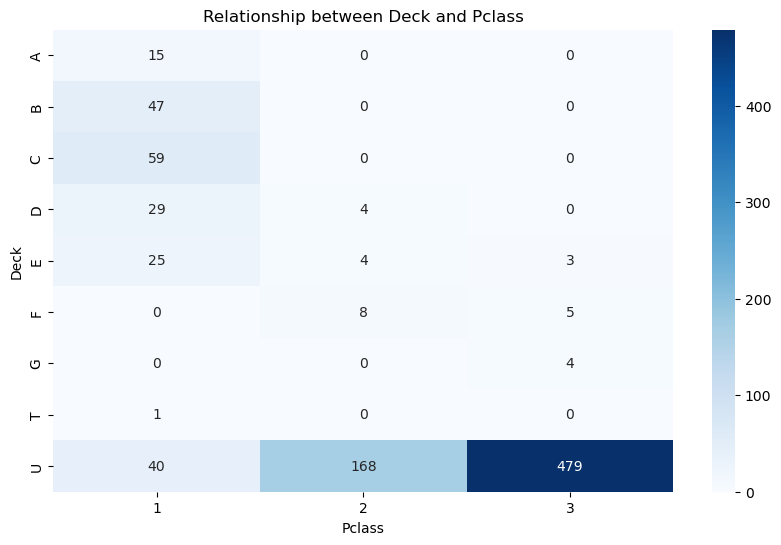

In [9]:
# Pclass별로 Deck 분포 확인
deck_pclass_dist = tmp.groupby(['Deck', 'Pclass']).size().unstack().fillna(0)

plt.figure(figsize=(10, 6))
sns.heatmap(deck_pclass_dist, annot=True, fmt='g', cmap='Blues')
plt.title("Relationship between Deck and Pclass")
plt.show()

In [10]:
import re
from sklearn.base import BaseEstimator, TransformerMixin

class TitanicFeatureEngineer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.ticket_counts_ = None

    def fit(self, X, y=None):
        X_ = X.copy()
        self.ticket_counts_ = (
            X_["Ticket"].value_counts(dropna=False) 
            if "Ticket" in X_.columns 
            else None
        )
        return self

    def transform(self, X):
        X_ = X.copy()

        # Title
        title = X_["Name"].astype(str).str.extract(r",\s*([^\.]+)\.")[0].fillna("Unknown")
        common = {"Mr","Miss","Mrs","Master"}
        X_["Title"] = title.where(title.isin(common), "Rare")

        # Family
        X_["FamilySize"] = X_["SibSp"].fillna(0) + X_["Parch"].fillna(0) + 1
        X_["IsAlone"] = (X_["FamilySize"] == 1).astype(int)

        # Deck
        X_["Deck"] = X_["Cabin"].fillna("U").astype(str).str[0]

        # TicketGroupSize (fold-safe: uses counts learned in fit)
        if self.ticket_counts_ is not None:
            X_["TicketGroupSize"] = X_["Ticket"].map(self.ticket_counts_).fillna(1).astype(int)
        else:
            X_["TicketGroupSize"] = 1

        # FarePerPerson
        denom = X_["FamilySize"].replace(0, 1)
        X_["FarePerPerson"] = X_["Fare"] / denom

        # Treat Pclass as categorical
        X_["Pclass"] = X_["Pclass"].astype("Int64").astype(str)

        # Drop raw high-cardinality columns
        X_ = X_.drop(columns=["Name","Cabin","Ticket"], errors="ignore")

        return X_


In [11]:
fe = TitanicFeatureEngineer().fit(X)
X_fe = fe.transform(X)

num_cols = X_fe.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X_fe.select_dtypes(exclude=[np.number]).columns.tolist()

print("Numeric:", num_cols)
print("Categorical:", cat_cols)
display(X_fe.head(3))


Numeric: ['PassengerId', 'Age', 'SibSp', 'Parch', 'Fare', 'FamilySize', 'IsAlone', 'TicketGroupSize', 'FarePerPerson']
Categorical: ['Pclass', 'Sex', 'Embarked', 'Title', 'Deck']


,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,FamilySize,IsAlone,Deck,TicketGroupSize,FarePerPerson
0,1,3,male,22.0,1,0,7.2500,S,Mr,2,0,U,1,3.62500
1,2,1,female,38.0,1,0,71.2833,C,Mrs,2,0,C,1,35.64165
2,3,3,female,26.0,0,0,7.9250,S,Miss,1,1,U,1,7.92500


In [12]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score

try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

numeric_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
])

categorical_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", ohe),
])

preprocess = ColumnTransformer([
    ("num", numeric_pipe, num_cols),
    ("cat", categorical_pipe, cat_cols),
])

model = RandomForestClassifier(
    n_estimators=600,
    min_samples_leaf=2,
    min_samples_split=4,
    max_features="sqrt",
    n_jobs=-1,
    random_state=42,
)

pipe = Pipeline([
    ("feat", TitanicFeatureEngineer()),
    ("prep", preprocess),
    ("model", model),
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(pipe, X, y, cv=cv, scoring="accuracy")
print(scores.mean(), scores.std())


0.8394827694432239 0.011843461906883885
